In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Create the inspector and connect to the engine
# collect the name of the tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# collect the names and data types for the measurement table
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# collect the names and data types for the station table
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

Most recent date in the data set is: 2017-08-23
Date one year from the most recent date is 2016-08-23


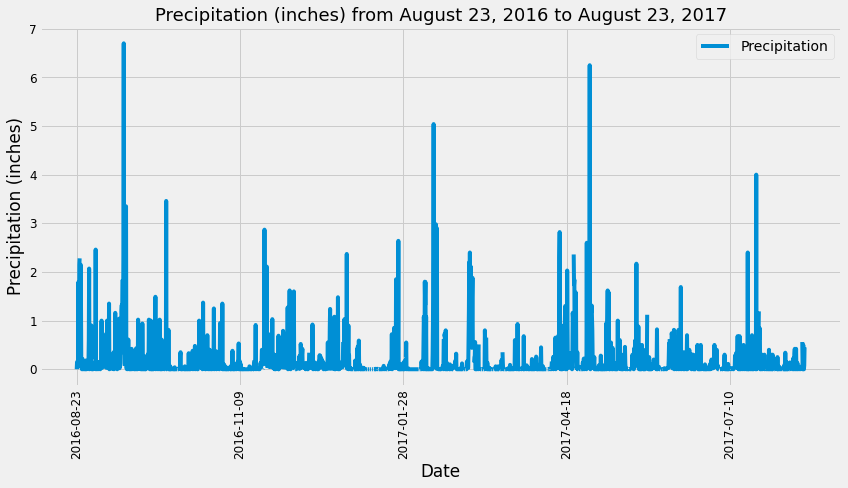

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(f"Most recent date in the data set is: {most_recent_date}")

# Calculate the date one year from the last date in data set.
last_date = (dt.datetime.strptime(most_recent_date, "%Y-%m-%d")).date()
date_oneyearago = last_date - dt.timedelta(days=365)
print(f"Date one year from the most recent date is {date_oneyearago}")

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date_oneyearago).order_by(measurement.date).all()
# print(prcp_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date').head(100)

# Use Pandas Plotting with Matplotlib to plot the data
x = 'Date'
y = 'Precipitation'
prcp_df.plot(x,y, figsize=(12,7), fontsize=12, rot=90)
plt.title(f"Precipitation (inches) from August 23, 2016 to August 23, 2017", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.tight_layout()
plt.savefig("Graphs/Percipitation Within Last Year.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_num_of_stations = session.query(station.id).count()
print(f"There are total of {total_num_of_stations} number of stations in the dataset.")

There are total of 9 number of stations in the dataset.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
for station in active_station_count:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
most_active_station = active_station_count[0][0]
most_active_station

'USC00519281'

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# active_summary = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs).filter(measurement.station == station.station).filter(measurement.station == most_active_station))
lowest_temperature = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

highest_temperature = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

average_temperature = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

#########################################################################################
print("Most Active Station Summary")
print("----------------------------------------")
print(f"Most active station is {most_active_station}.")
print(f"Lowest Temperature: {lowest_temperature} Degrees")
print(f"Highest Temperature: {highest_temperature} Degrees")
print(f"Average Temperature: {round(average_temperature,2)} Degrees")

Most Active Station Summary
----------------------------------------
Most active station is USC00519281.
Lowest Temperature: 54.0 Degrees
Highest Temperature: 85.0 Degrees
Average Temperature: 71.66 Degrees


In [19]:
# Using the most active station id 
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs = pd.DataFrame(session.query(measurement.tobs).filter((measurement.station == most_active_station) & (measurement.date >= date_oneyearago) & (measurement.date <= last_date)).all(), columns = ['Tobs'])
most_active_station_tobs.head()

,Tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


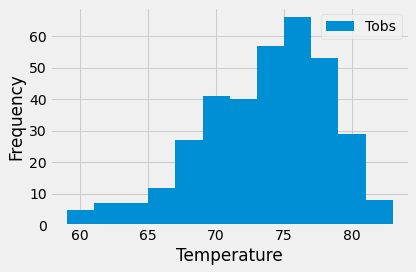

In [20]:
# Plot the results as a histogram with bins=12
most_active_station_tobs.plot(kind = 'hist', bins = 12,legend = True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Graphs/Most Active Station Tobe.png")
plt.show()

# Close session

In [21]:
# Close Session
session.close()